# graph layout
with Formula 1 data from https://ergast.com/mrd/db/

In [1]:
%autosave 0
%load_ext autoreload
%autoreload 2

from tools import DATADIR, F1_ZIPPED
from etl.ergast import ErgastF1
from viz.graph import Graph
from viz.plot import Plot

f1 = ErgastF1(F1_ZIPPED)
plot = Plot('dark_background')
folder = DATADIR / 'graph'
core = 'Martin Brundle'

Autosave disabled


In [2]:
from itertools import permutations
from pandas import DataFrame, Series

In [3]:
%%time
mates = (
    f1.results['id_driver id_race id_team'.split()]
    .join(f1.races['season race'.split()], on='id_race')
    .join(f1.drivers['driver'], on='id_driver')
    .join(f1.teams['team'], on='id_team')
    .groupby('season race team'.split())['driver']
    .apply(lambda s: list(permutations(s, 2)))
    .explode()
)
mates = DataFrame(mates.tolist(),index = mates.index)
mates.columns = 'source target'.split()
mates

CPU times: user 1.43 s, sys: 20 ms, total: 1.45 s
Wall time: 1.46 s


source            target
season race                     team                                         
1950   Belgian Grand Prix       Alfa Romeo      Juan Fangio     Luigi Fagioli
                                Alfa Romeo      Juan Fangio       Nino Farina
                                Alfa Romeo    Luigi Fagioli       Juan Fangio
                                Alfa Romeo    Luigi Fagioli       Nino Farina
                                Alfa Romeo      Nino Farina       Juan Fangio
...                                                     ...               ...
2019   United States Grand Prix Renault     Nico Hülkenberg  Daniel Ricciardo
                                Toro Rosso     Daniil Kvyat      Pierre Gasly
                                Toro Rosso     Pierre Gasly      Daniil Kvyat
                                Williams     George Russell     Robert Kubica
                                Williams      Robert Kubica    George Russell

[40420 rows x 2 columns]

In [4]:
graph = Graph(mates)
graph

Graph with 9988 links
              source                 target  weight
0       Adolf Brudes            Fritz Riess       1
1       Adolf Brudes             Hans Klenk       1
2       Adolf Brudes           Josef Peters       1
3       Adolf Brudes           Paul Pietsch       1
4       Adolf Brudes          Theo Helfrich       1
...              ...                    ...     ...
9983  Óscar González             Jean Behra       1
9984  Óscar González  José Froilán González       1
9985  Óscar González           Luigi Piotti       1
9986  Óscar González          Mike Hawthorn       1
9987  Óscar González          Stirling Moss       1

[9988 rows x 3 columns]

## brundlegree

790 drivers within 7 degrees of Martin Brundle


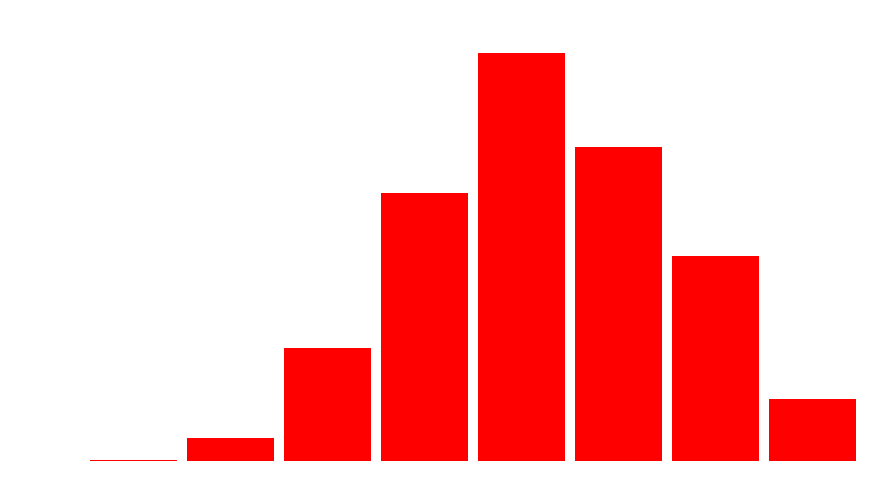

In [5]:
def bacondeg(graph, core):
    nodes = graph.nodes
    source = graph.links['source']
    target = graph.links['target']

    frontier = {core}
    bacon = Series(-1, index=nodes)
    for i in range(100):
        bacon[frontier] = i
        marked = set(nodes[bacon.gt(-1)])
        frontier = set(target[source.isin(frontier)]) - marked
        if not frontier:
            return bacon

def showbacon(graph, core, **kwargs):
    kwargs.setdefault('color', 'r')
    kwargs.setdefault('legend', False)
    kwargs.setdefault('title', f"degrees from {core}")
    kwargs.setdefault('ylabel', 'number of F1 drivers')
    
    data = bacondeg(graph, core)
    data = data[data >= 0].value_counts().sort_index()
    maxdeg = data.index.max()
    print(f"{data.sum()} drivers within {maxdeg} degrees of {core}")
    
    return plot.bar(data, **kwargs)
     
axes = showbacon(graph, core)
axes.figure.savefig(folder / 'brundlegree.png')

## doppelgänger

In [6]:
doppels = (
    graph.links
    .sort_values('weight', ascending=False)
    .iloc[:20:2, :].reset_index(drop=True)
)
doppels.columns = 'driver driver races'.split()
doppels.index += 1
doppels.to_csv(folder / 'doppels.csv')
doppels

,driver,driver,races
1,Rubens Barrichello,Michael Schumacher,104
2,David Coulthard,Mika Häkkinen,99
3,Mark Webber,Sebastian Vettel,94
4,Kimi Räikkönen,Sebastian Vettel,81
5,Lewis Hamilton,Nico Rosberg,78
6,Felipe Massa,Fernando Alonso,77
7,Jean Alesi,Gerhard Berger,77
8,Jenson Button,Rubens Barrichello,70
9,Elio de Angelis,Nigel Mansell,62
10,Maurício Gugelmin,Ivan Capelli,62


## voyagers

In [7]:
vgers = bacondeg(graph, core)
vgers = vgers.index[vgers < 0]
vgers = (
    f1.drivers
    .loc[lambda df: df['driver'].isin(vgers)]
    ['driver nation birthday'.split()]
    .sort_values('birthday')
    .reset_index(drop=True)
)
vgers.index += 1
vgers.to_html(folder / 'voyagers.html')
vgers

,driver,nation,birthday
1,Bill Cantrell,American,1908-01-31
2,Joe Kelly,Irish,1913-03-13
3,Bayliss Levrett,American,1914-02-14
4,Paul Emery,British,1916-11-12
5,Geoff Crossley,British,1921-05-11
6,Peter Broeker,Canadian,1926-05-15
7,Bernie Ecclestone,British,1930-10-28
8,Bruce Kessler,American,1936-03-23
9,Ernie de Vos,Dutch,1941-07-01
10,Jules Bianchi,French,1989-08-03


## use the force

In [8]:
%%time
frame = graph.frame(1200)
frame['degree'] = bacondeg(graph, core)
frame['nraces'] = graph.links.groupby('source')['weight'].sum()
frame = (
    frame.loc[frame['degree'].ge(0)]
    .sort_values('nraces degree'.split(), ascending=False)
    .join(f1.drivers.set_index('driver')['url'])
    .rename_axis('driver')
)
frame.to_csv(folder / 'brundle.csv')
frame.head()

CPU times: user 45.8 s, sys: 0 ns, total: 45.8 s
Wall time: 45.8 s


,x,y,degree,nraces,url
driver,,,,,
Jack Brabham,0.446151,-0.115774,3,349,http://en.wikipedia.org/wiki/Jack_Brabham
Rubens Barrichello,-0.593039,-0.233375,1,326,http://en.wikipedia.org/wiki/Rubens_Barrichello
Stirling Moss,0.463982,0.105810,4,319,http://en.wikipedia.org/wiki/Stirling_Moss
Graham Hill,0.346001,-0.274204,3,317,http://en.wikipedia.org/wiki/Graham_Hill
Kimi Räikkönen,-0.627531,-0.304072,3,315,http://en.wikipedia.org/wiki/Kimi_R%C3%A4ikk%C...


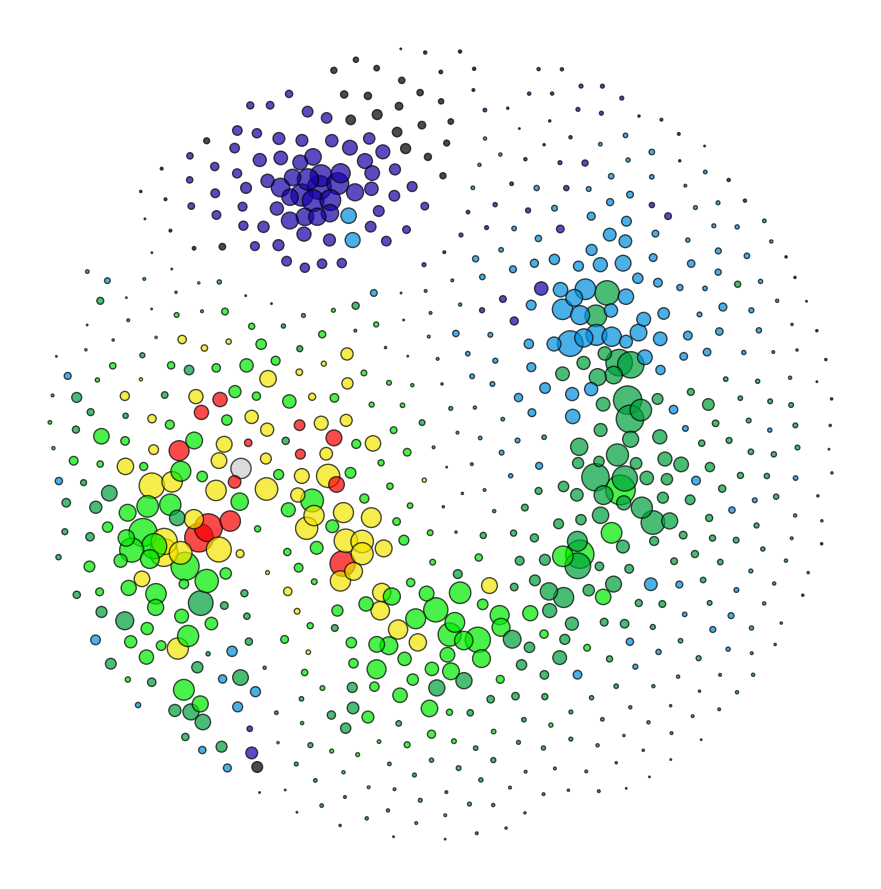

In [9]:
def show(frame, core, **kwargs):
    kwargs.setdefault('cmap', 'nipy_spectral_r')
    kwargs.setdefault('edgecolor', 'black')
    kwargs.setdefault('figsize', (9, 9))
    kwargs.setdefault('grid', False)
    kwargs.setdefault('xticks', [])
    kwargs.setdefault('yticks', []) 

    data = frame[frame['degree'].ge(0)].copy()
    data['nraces'] *= 64 / data['nraces'].mean()
    axes = plot.scatter(data, **kwargs)
    axes.set_aspect('equal', 'box')

    return axes
    
axes = show(frame, core)
axes.figure.savefig(folder / 'brundle.png')